<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202520/blob/main/Lecture05/Notebook_Ridge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Regularization: Ridge

## Predicting Wages

Our objective today is to construct a model of individual wages

$$
w = f(X) + u 
$$

where w is the  wage, and X is a matrix that includes potential explanatory variables/predictors. In this problem set, we will focus on a linear model of the form

\begin{align}
 ln(w) & = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p  + u 
\end{align}

were $ln(w)$ is the logarithm of the wage.

To illustrate I'm going to use a sample of the NLSY97. The NLSY97 is  a nationally representative sample of 8,984 men and women born during the years 1980 through 1984 and living in the United States at the time of the initial survey in 1997.  Participants were ages 12 to 16 as of December 31, 1996.  Interviews were conducted annually from 1997 to 2011 and biennially since then.  

Let's load the packages and the data set:

In [53]:
#install.packages("pacman") #for google colab

In [54]:
#packages
require("pacman")
p_load("tidyverse","stargazer")

nlsy <- read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/nlsy97.csv')

nlsy <- nlsy  %>%   drop_na(educ) #dropea los valores faltantes (NA)

Rows: 1266 Columns: 994
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (994): lnw_2016, educ, black, hispanic, other, exp, afqt, mom_educ, dad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We want to construct a model that predicts well out of sample, and we have potentially 994 regressors. We are going to regularize this regression using Ridge.

## Ridge

We first illustrate ridge regression, which can be fit using glmnet() with alpha = 0 and seeks to minimize

$$
\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}    \right) ^ 2 + \lambda \sum_{j=1}^{p} \beta_j^2 .
$$

Notice that the intercept is not penalized. 


Ridge penalizes the squares  of the coefficients. As a result, ridge shrinks coefficients toward zero, but not all the way.

We are going to use Glmnet. Glmnet is a package that fits generalized linear and similar models via penalized maximum likelihood. The regularization path is computed for the lasso or elastic net penalty at a grid of values (on the log scale) for the regularization parameter lambda. The algorithm is extremely fast!

## Glmnet

To apply a regularized model we can use the `glmnet::glmnet()` function. The `alpha` parameter tells glmnet to perform a ridge (`alpha` = 0), lasso (`alpha` = 1), or elastic net (0 < `alpha` < 1) model. 

By default, `glmnet` will do two things that you should be aware of:

1. Since regularized methods apply a penalty to the coefficients, we need to ensure our coefficients are on a common scale. If not, then predictors with naturally larger values  will be penalized more than predictors with naturally smaller values. By default, `glmnet` automatically standardizes your features. If you standardize your predictors prior to glmnet you can turn this argument off with `standardize = FALSE`.

2. `glmnet` will fit ridge models across a wide range of  $\lambda$  values, which is illustrated below:

`glmnet` has some drawbacks, the main one is that we need to specify the arguments in terms of matrices and vectors:

In [55]:
p_load("glmnet")

#Vector that needs predicting
y <- nlsy$lnw_2016


# Matrix of predictos (only educ, mother and father's education)
X <- as.matrix(nlsy  %>% select(educ,mom_educ,dad_educ))



Let's run the ridge regression (we need to set the parameter `alpha` to zero)

In [56]:

ridge <- glmnet(
  x = X,
  y = y,
  alpha = 0 #ridge
)

Let's see how  how much the coefficients are penalized for different values of $\lambda$. Notice none of the coefficients are forced to be zero, although they get close to it.

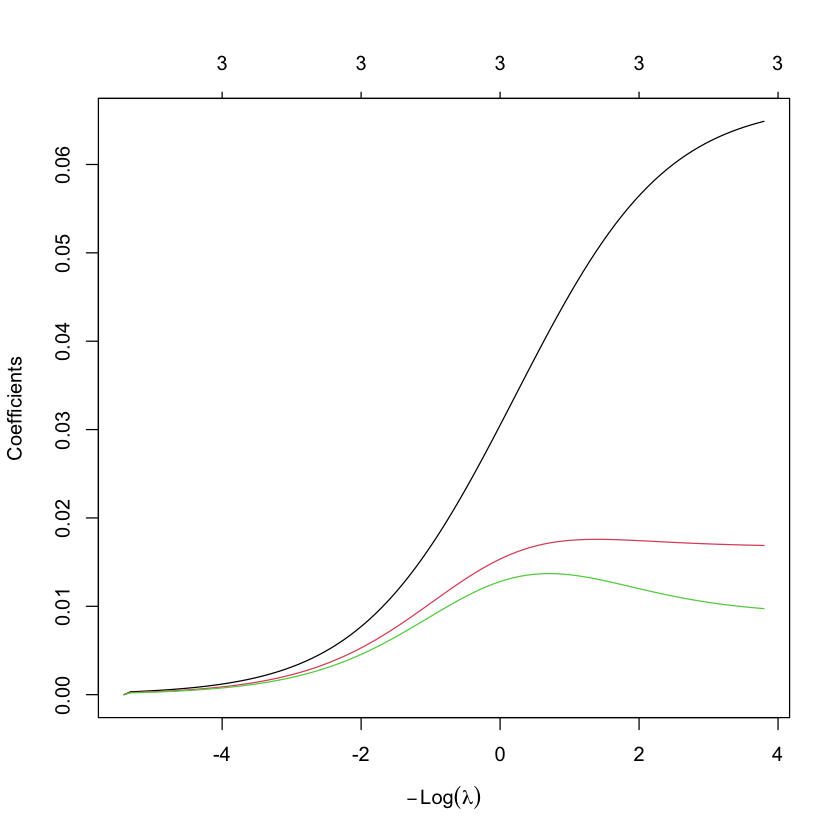

In [57]:
plot(ridge, xvar = "lambda")

#### All the predictors

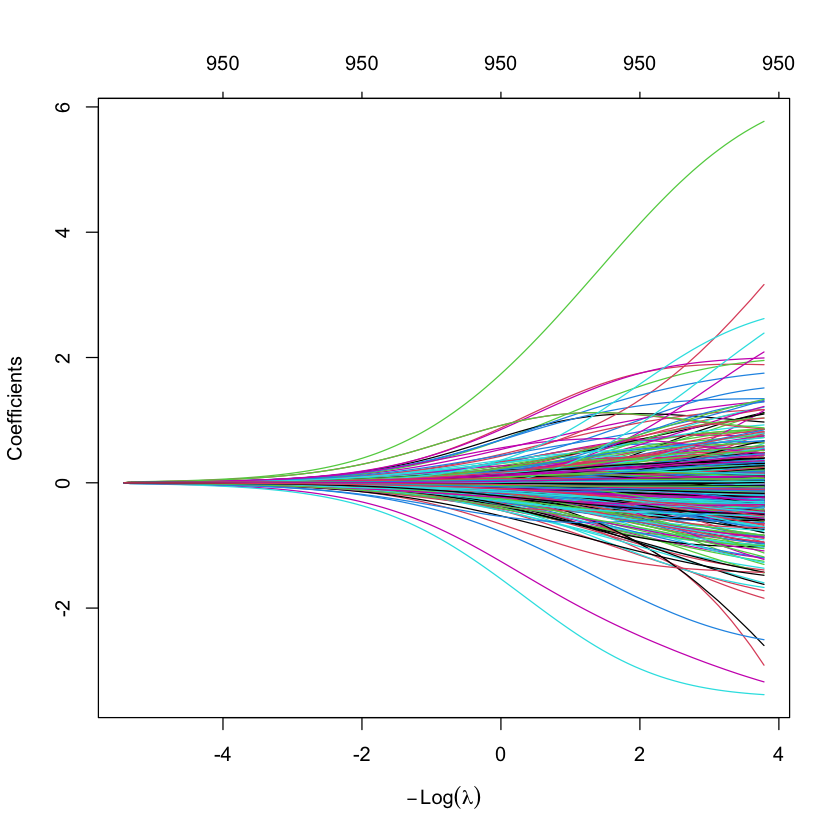

In [58]:

# Matrix of predictos (all but lnw_2016)
X <- as.matrix(nlsy  %>% select(-lnw_2016))

ridge <- glmnet(
  x = X,
  y = y,
  alpha = 0 #ridge
)

plot(ridge, xvar = "lambda")

## Scale Equivariance

We are going to illustrate the scale problems using just education and afqt scores


In [59]:

#Vector that needs predicting
y <- nlsy$lnw_2016

# Matrix of predictos (only educ and afqt)
X <- as.matrix(nlsy  %>% select(educ,afqt))



In [60]:
stargazer(data.frame(X),type="text")


Statistic   N    Mean  St. Dev.  Min   Max  
--------------------------------------------
educ      1,266 14.314  2.900     8     20  
afqt      1,266 5.325   2.915   0.000 10.000
--------------------------------------------


Let's run the ridge regression (we need to set the parameter `alpha` to zero)

In [61]:
ridge <- glmnet(
  x = X,
  y = y,
  alpha = 0, #ridge
  lambda=20,
  standardize=TRUE
)

Let's see the coefficients we obtained


In [62]:
coef(ridge)

3 x 1 sparse Matrix of class "dgCMatrix"
                     s0
(Intercept) 3.047993093
educ        0.003143716
afqt        0.003167592

Compare to OLS

In [63]:
ols<-lm(y~X)
summary(ols)


Call:
lm(formula = y ~ X)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6858 -0.4214 -0.0299  0.3514  4.5426 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.147862   0.121059  17.742  < 2e-16 ***
Xeduc       0.048462   0.009813   4.939 8.92e-07 ***
Xafqt       0.050380   0.009764   5.160 2.87e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8317 on 1263 degrees of freedom
Multiple R-squared:  0.08583,	Adjusted R-squared:  0.08438 
F-statistic: 59.29 on 2 and 1263 DF,  p-value: < 2.2e-16


### What happens if we change the scale for education?

In [64]:
X_mil<-X
X_mil[,1]<-X[,1]*1000 #multiply first column by 1000


In [65]:
head(X_mil)


educ,afqt
16000,7.0724
9000,4.7481
9000,1.1987
16000,8.9321
16000,2.2618
16000,8.9502


In [66]:
ridge_mil <- glmnet(
  x = X_mil,
  y = y,
  alpha = 0, #ridge
 lambda=700
)

In [67]:
coef(ridge_mil)[2]

[1] 9.57873e-08

In [68]:
coef(ridge)[2]

[1] 0.003143716

In [69]:
coef(ridge_mil)[2]*1000

[1] 9.57873e-05

In [70]:
ols_1000<-lm(y~X_mil)
summary(ols_1000)


Call:
lm(formula = y ~ X_mil)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6858 -0.4214 -0.0299  0.3514  4.5426 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.148e+00  1.211e-01  17.742  < 2e-16 ***
X_mileduc   4.846e-05  9.813e-06   4.939 8.92e-07 ***
X_milafqt   5.038e-02  9.764e-03   5.160 2.87e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8317 on 1263 degrees of freedom
Multiple R-squared:  0.08583,	Adjusted R-squared:  0.08438 
F-statistic: 59.29 on 2 and 1263 DF,  p-value: < 2.2e-16


In [71]:
ols_1000$coefficients[2]*1000

X_mileduc 
0.04846231

In [72]:
ols$coefficients[2]

Xeduc 
0.04846231